READ ME
---
**Training Dataset:** datatrain.data (6000+sentences) 

--> pick small subset of data in **Manage Data section**

```
# for i in datatofile[:100]:

```
---
Can run all 👍🏼


# ThaiNER (Bi-LSTM CRF)

using pytorch

from https://github.com/ekapolc/nlp_course/blob/master/PyTorchDemo/pytorch_tute_lstm.ipynb and https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html

By Mr.Wannaphong Phatthiyaphaibun

Bachelor of Science Program in Computer and Information Science, Nong Khai Campus, Khon Kaen University

https://iam.wannaphong.com/

E-mail : wannaphong@kkumail.com

Thank you Faculty of Applied Science and Engineering, Nong Khai Campus, Khon Kaen University for server.

# **Implement A Named Entity Recognizer (Bi-LSTM + CRF)**


a) Implement according to https://aclanthology.org/N16-1030/, using a dataset from
https://nlpforthai.com/tasks/ner/ (a very small subset is sufficient for demonstration)



b) You can put together the model from code available in any package


## Load Data

In [1]:
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import dill
with open('/content/drive/MyDrive/NLP/datatrain.data', 'rb') as file:

 datatofile = dill.load(file)

In [4]:
# tagged_sents = []
# for i in datatofile:
#     text_inside = []
#     for j in i:
#         text_inside.append((j[0],j[2]))
#     tagged_sents.append(text_inside)
# train_sents, test_sents= train_test_split(tagged_sents, test_size=0.2, random_state=112)

In [5]:
# import dill
# with open('datatrain.data', 'rb') as file:
#  datatofile = dill.load(file)

In [6]:
datatofile[1]

[('สงสัย', 'NCMN', 'O'),
 ('ติด', 'VACT', 'O'),
 ('หวัด', 'NCMN', 'O'),
 ('นก', 'DDAC', 'O'),
 (' ', 'NCMN', 'O'),
 ('อีก', 'DDBQ', 'O'),
 ('คน', 'NCMN', 'O'),
 ('ยัง', 'XVBM', 'O'),
 ('น่า', 'VSTA', 'O'),
 ('ห่วง', 'NCMN', 'O')]

In [7]:
len(datatofile)

6148

## Import Libraries

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import sklearn
from sklearn.model_selection import cross_validate,train_test_split
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

print(torch.__version__)

2.0.1+cu118


Prepare for GPU else CPU

In [9]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#torch.backends.cudnn.benchmark=torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.long
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [10]:
USE_CUDA

False

## Manage Data

Get list of word_ner = [[word],[ner]]
* data[0] = word
* data[1] = POS
* data[2] = NER

In [11]:
# Pick a small subset to train
word_ner=[]
for i in datatofile[:1000]:
    t1=[]
    t2=[]
    for j in i:
        t1.append(j[0])
        t2.append(j[2])
    word_ner.append((t1,t2))

In [13]:
tagged_sents = word_ner

## Define Function and Model

Function

In [14]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else to_ix["UNK"] for w in seq]
    return torch.tensor(idxs, dtype=LongTensor, device=device)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

**Model: BiLSTM + CRF**

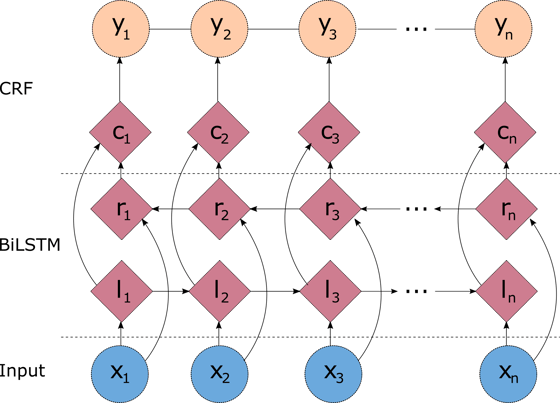




In [15]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix

        self.tagset_size = len(tag_to_ix)

        self.dropout = nn.Dropout(0.5)  # Not sure****
      
        #Word Embedding
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
      
        #LSTM Layer (Bidirectional = True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of transitioning *to* i *from* j.
        # Transition Probability
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size, device=device))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag

        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2,device=device),
                torch.randn(2, 1, self.hidden_dim // 2,device=device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000., device=device)

        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep

            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of the previous tag
                # Emission Probaboloty
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)

                # the ith entry of trans_score is the score of transitioning to next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)

                # The ith entry of next_tag_var is the value for the edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score

                # The forward variable for this tag is log-sum-exp of all the scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            
            forward_var = torch.cat(alphas_t).view(1, -1)

        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)

        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1,device=device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=LongTensor, device=device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                    self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]

        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]

        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000., device=device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars

        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))

            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
            
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

---

In [16]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 64
HIDDEN_DIM = 128

In [17]:
#split data into train set and test set
train_size = int(len(tagged_sents) * 0.8)
train_sents = tagged_sents[:train_size]
test_sents = tagged_sents[train_size:]

In [50]:
train_sents[1]

(['สงสัย', 'ติด', 'หวัด', 'นก', ' ', 'อีก', 'คน', 'ยัง', 'น่า', 'ห่วง'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

## Preparing the Data

In [19]:
word_list=[]
ner_list=[]

for sent,tags in train_sents:
    for word in sent:
        word_list.append(word)
    for tag in tags:
        ner_list.append(tag)

# Word to Index
word_list.append("UNK") #Special Token for unknown words
ner_list.append(START_TAG)
ner_list.append(STOP_TAG)
all_words = sorted(set(word_list))
all_pos = sorted(set(ner_list))
# del word_list, pos_list

word_to_ix = dict((c, i) for i, c in enumerate(all_words)) #convert all words to index 
ner_to_ix = dict((c, i) for i, c in enumerate(all_pos)) #convert all pos to index

In [20]:
print(ner_to_ix) # NER tags

{'<START>': 0, '<STOP>': 1, 'B-DATE': 2, 'B-LAW': 3, 'B-LEN': 4, 'B-LOCATION': 5, 'B-MONEY': 6, 'B-ORGANIZATION': 7, 'B-PERCENT': 8, 'B-PERSON': 9, 'B-PHONE': 10, 'B-TIME': 11, 'B-URL': 12, 'I-DATE': 13, 'I-LAW': 14, 'I-LEN': 15, 'I-LOCATION': 16, 'I-MONEY': 17, 'I-ORGANIZATION': 18, 'I-PERCENT': 19, 'I-PERSON': 20, 'I-PHONE': 21, 'I-TIME': 22, 'I-URL': 23, 'O': 24}


In [21]:
ix_to_word = dict((v,k) for k,v in word_to_ix.items()) #convert index to word
ix_to_ner = dict((v,k) for k,v in ner_to_ix.items())  #convert index to word

## Preparing the Data for PyTorch

In [22]:
model = BiLSTM_CRF(len(word_to_ix), ner_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
model.to(device)

BiLSTM_CRF(
  (dropout): Dropout(p=0.5, inplace=False)
  (word_embeds): Embedding(3873, 64)
  (lstm): LSTM(64, 64, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=25, bias=True)
)

In [23]:
tag_to_ix = ner_to_ix

In [24]:
# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

optimizer = optim.SGD(model.parameters(), lr=0.01)

# cgn = torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=5)
# drp = nn.Dropout(p=0.5)

In [25]:
# train_sents[5]

In [26]:
with torch.no_grad():
    precheck_sent = prepare_sequence(train_sents[5][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in train_sents[0][1]], dtype=LongTensor, device=device)
    print(precheck_sent)
    print(model(precheck_sent))

tensor([2636,  788, 1351, 2220,  832, 3745,  852,    0,  166,    0, 2379, 1580,
        1476,    0, 2737, 1351, 3055, 1293,    0,  350,    0,  349,    0, 1189,
        1565, 3249, 3426, 3171, 2456, 3810, 3320,    0, 3306,  428, 1025, 3726,
        1730, 1351,    0,  128,    0,  821, 1207, 1321, 3726, 2648, 1351, 2112,
         594,    0, 3595,  859, 2194, 2538,  503,  842, 2784, 1833,    0, 3326,
         491, 1351, 2110])
(tensor(140.1153), [13, 24, 7, 22, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 12, 24, 7, 22, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 16, 23, 12, 24, 7])


Train Function

In [27]:
def train(sentence, tags,train=True):
    if train:
        model.train(True)
    else:
        model.eval()

    model.zero_grad()
    sentence_in = prepare_sequence(sentence, word_to_ix)
    targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=LongTensor, device=device)
    loss = model.neg_log_likelihood(sentence_in, targets)
    
    if train:
        loss.backward()   # backprop
        optimizer.step()  # update parameters
        # cgn.step()
    return loss.item()

Set n_iters

In [30]:
import time
import math

n_iters = 10
print_every = 1

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
train_losses=[]
val_losses=[]

for iter in range(1, n_iters + 1):#Epoch
    loader = tqdm(train_sents, total=len(train_sents))

    for sentence, ner_tags in loader: #Sentence
        loss = train(sentence, ner_tags) #fwd
    loader = tqdm(train_sents, total=len(train_sents))

    for sentence, ner_tags in loader: #Sentence
        val_loss = train(sentence, ner_tags,train=False) #fwd
    
    # Print iter number,time, loss
    if iter % print_every == 0:
        # print('ep %d %d%% (%s) loss %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))
        # print('val loss %.4f ' % (val_loss))
        print(f'ep:{iter} {iter / n_iters * 100:%} ({timeSince(start)}) loss {loss:.4f} ')
        print(f'val loss {val_loss:.4f}')
        
        train_losses.append(loss)
        val_losses.append(val_loss)
        torch.save(model.state_dict(), "ner-2.pt.ep"+str(iter))

100%|██████████| 800/800 [01:54<00:00,  6.98it/s]


ep:1 1000.000000% (5m 47s) loss 0.4915 
val loss 0.4006


100%|██████████| 800/800 [01:54<00:00,  6.98it/s]


ep:2 2000.000000% (11m 42s) loss 0.3987 
val loss 0.3323


100%|██████████| 800/800 [01:55<00:00,  6.95it/s]


ep:3 3000.000000% (17m 34s) loss 0.3264 
val loss 0.2726


100%|██████████| 800/800 [01:54<00:00,  6.98it/s]


ep:4 4000.000000% (23m 25s) loss 0.2323 
val loss 0.2080


100%|██████████| 800/800 [01:57<00:00,  6.82it/s]


ep:5 5000.000000% (29m 19s) loss 0.2045 
val loss 0.1747


100%|██████████| 800/800 [01:56<00:00,  6.84it/s]


ep:6 6000.000000% (35m 16s) loss 0.1603 
val loss 0.1532


100%|██████████| 800/800 [01:55<00:00,  6.94it/s]


ep:7 7000.000000% (41m 10s) loss 0.1484 
val loss 0.1348


100%|██████████| 800/800 [01:54<00:00,  6.97it/s]


ep:8 8000.000000% (47m 1s) loss 0.1266 
val loss 0.1273


100%|██████████| 800/800 [01:55<00:00,  6.95it/s]


ep:9 9000.000000% (52m 53s) loss 0.1189 
val loss 0.1124


100%|██████████| 800/800 [01:54<00:00,  6.98it/s]

ep:10 10000.000000% (58m 44s) loss 0.1160 
val loss 0.1152


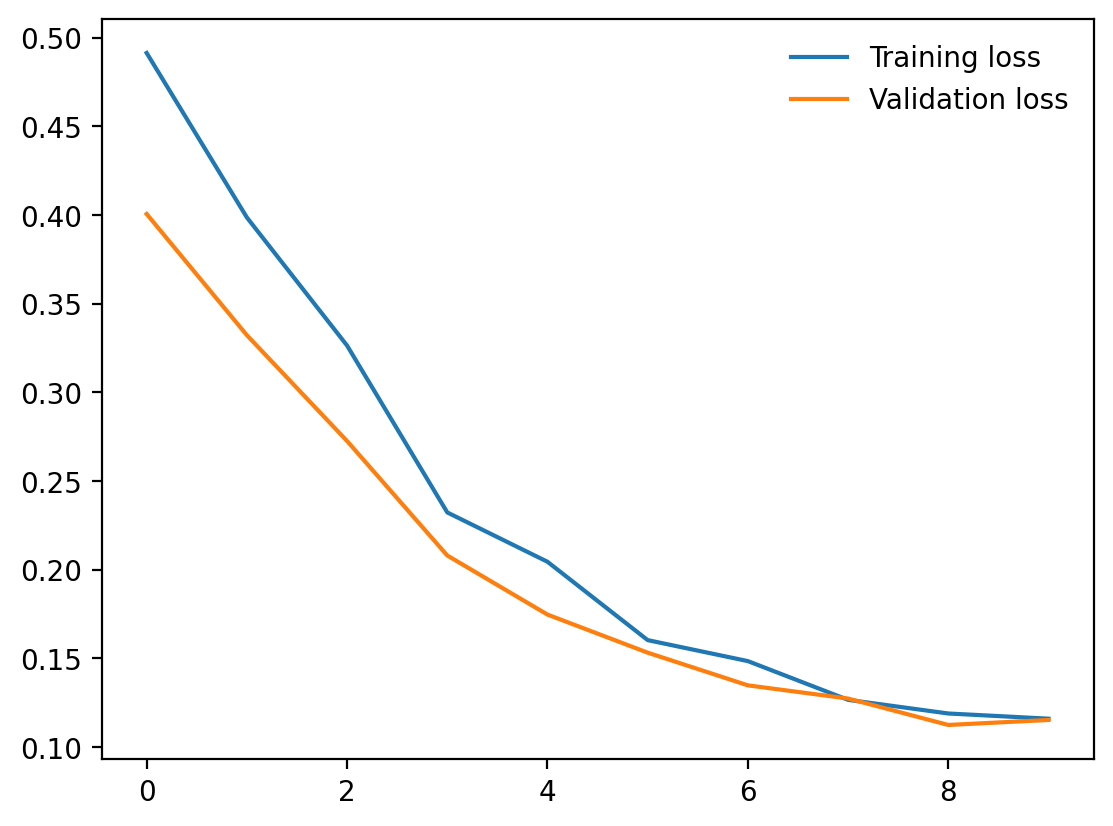

In [31]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [32]:
with torch.no_grad():
    precheck_sent = prepare_sequence(train_sents[5][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in train_sents[0][1]], dtype=LongTensor, device=device)
    print(precheck_sent)
    print(model(precheck_sent))

tensor([2636,  788, 1351, 2220,  832, 3745,  852,    0,  166,    0, 2379, 1580,
        1476,    0, 2737, 1351, 3055, 1293,    0,  350,    0,  349,    0, 1189,
        1565, 3249, 3426, 3171, 2456, 3810, 3320,    0, 3306,  428, 1025, 3726,
        1730, 1351,    0,  128,    0,  821, 1207, 1321, 3726, 2648, 1351, 2112,
         594,    0, 3595,  859, 2194, 2538,  503,  842, 2784, 1833,    0, 3326,
         491, 1351, 2110])
(tensor(938.8936), [24, 24, 24, 24, 24, 24, 24, 24, 6, 17, 17, 17, 24, 24, 24, 24, 24, 24, 24, 7, 24, 7, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24])


In [33]:
with torch.no_grad():
    print(model(prepare_sequence(test_sents[2][0], word_to_ix))[1])
    print(test_sents[1][0])

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
['http', '://', 'www', '.', 'bangkokhealth', '.', 'com', '/', 'healthnews', ' ', '_', ' ', 'htdoc', '/', 'healthnews', ' ', '_', ' ', 'detail', '.', 'asp', '?', 'Number', '=', '10056']


In [35]:
def predict(input_sent):
    y_pred=[]
    temp=[]
    with torch.no_grad():
        precheck_sent = prepare_sequence(input_sent, word_to_ix)
        output=model(precheck_sent)[1]
        y_pred=[ix_to_ner[i] for i in output]
    
    return y_pred

In [36]:
print(test_sents[2][0])
print(predict(test_sents[2][0]))
print(test_sents[2][1])

['หนักใจ', 'อาการ', 'เด็ก', 'แฝด', 'ติด', 'หวัด', 'นก', 'ยัง', 'ไม่', 'พ้นขีดอันตราย']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [37]:
# for test_sent,_ in test_sents[:len(test_sents)-2]:
#     print(test_sent)

Test if there is any unknown word

In [38]:
y_pred = []

for test_sent,_ in test_sents:
    try:
        temp_pred = predict(test_sent)
        y_pred.append(temp_pred)
    except:
        print(test_sent)

In [39]:
test_targets =[ner1 for sent,ner1 in test_sents if sent!=[]]

In [40]:
# test_sents[1]

## Classification Report

In [41]:
def ner_classification_report(y_true, y_pred):
 
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
    tagset = list(sorted(set(lb.classes_)))
    print(tagset)
    del tagset[len(tagset)-1] # del O
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset if cls!="O"],
        target_names = tagset,
        digits=4
    )

In [42]:
print(ner_classification_report(test_targets,y_pred))

['B-DATE', 'B-LOCATION', 'B-ORGANIZATION', 'B-PERSON', 'B-PHONE', 'B-TIME', 'B-URL', 'I-DATE', 'I-LOCATION', 'I-ORGANIZATION', 'I-PERSON', 'I-PHONE', 'I-TIME', 'I-URL', 'O']
                precision    recall  f1-score   support

        B-DATE     0.9091    0.8000    0.8511        25
    B-LOCATION     0.8235    0.7636    0.7925        55
B-ORGANIZATION     0.8442    0.7647    0.8025        85
      B-PERSON     0.9306    0.9054    0.9178        74
       B-PHONE     0.0000    0.0000    0.0000         1
        B-TIME     1.0000    0.4828    0.6512        29
         B-URL     1.0000    0.7500    0.8571         4
        I-DATE     0.9375    0.7317    0.8219        41
    I-LOCATION     0.6512    0.6829    0.6667        41
I-ORGANIZATION     0.6562    0.6462    0.6512        65
      I-PERSON     0.9252    0.8646    0.8939       229
       I-PHONE     0.0000    0.0000    0.0000         4
        I-TIME     1.0000    0.4762    0.6452        63
         I-URL     1.0000    0.9231    0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test

In [43]:
predict(["ผม","ชื่อ","นาย","บุญ","มาก"," ","ทอง","ดี"])

['O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O']

In [44]:
predict(["ผม","เดิน","ทาง","ไป","เรียน","ที่","บางกะปิ"])

['O', 'O', 'O', 'O', 'O', 'O', 'O']

In [45]:
predict(["ฉัน","ง่วง","นอน"])

['O', 'O', 'O']

In [46]:
len(word_to_ix)

3873

# Save Best Model and Word,POS Index to File

In [47]:
# import dill
# with open('word_to_ix.pkl', 'wb') as file:
#     dill.dump(word_to_ix, file)

In [48]:
# with open('pos_to_ix.pkl', 'wb') as file:
#     dill.dump(pos_to_ix, file)

In [49]:
# torch.save(model.state_dict(), "thainer.model")